In [2]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import defaultdict
import faiss

In [3]:
# Load in uniprot meta data
meta_data_new = pd.read_csv('/home/ron/protein-vec/src_run/data/uniprotkb_AND_reviewed_true_2023_07_03.tsv', sep='\t')
lookup_proteins_meta = pd.read_csv('/home/ron/protein-vec/src_run/protein_vec_embeddings/lookup_embeddings_meta_data.tsv', sep="\t")

In [4]:
# Now filter for the proteins that were newly discovered
new_proteins = meta_data_new[meta_data_new['Date of creation'] > '2022-05-25'].reset_index(drop=True)
# verify that new protein Entry is not in the lookup database Entry
print(f"new proteins in lookup_proteins meta {new_proteins['Entry'].isin(lookup_proteins_meta['Entry']).sum()}")

In [10]:
# TODO: not sure what I was doing here

# get proteins in meta_data_new that are not in lookup_proteins_meta
new_proteins_not_in_lookup = new_proteins[~new_proteins['Entry'].isin(lookup_proteins_meta['Entry'])].reset_index(drop=True)
len(new_proteins_not_in_lookup), len(new_proteins)

In [7]:
lookup_embeddings = np.load('/home/ron/protein-vec/src_run/protein_vec_embeddings/lookup_embeddings.npy')

In [8]:
query_embeddings = np.load('/home/ron/protein-vec/src_run/protein_vec_embeddings/new_protein_embeddings.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/home/ron/protein-vec/src_run/protein_vec_embeddings/new_protein_embeddings.npy'

In [6]:
column = 'Pfam'

In [10]:
# select proteins and their embeddings only for proteins that have a Pfam domain
col_proteins_meta = lookup_proteins_meta[~lookup_proteins_meta[column].isnull()]
col_embeddings = embeddings[col_proteins_meta.index]
# drop index to avoid confusion
col_proteins_meta = col_proteins_meta.reset_index(drop=True)

In [11]:
len(col_proteins_meta), len(col_embeddings)

(517951, 517951)

In [17]:
# split into train and test set and get the respective embeddings (using the index of the proteins)
np.random.seed(0)
# col_lookup = col_proteins_meta.sample(frac=0.8)
# col_query = col_proteins_meta[~col_proteins_meta.index.isin(col_lookup.index)]

# select new proteins for the query set
col_query = new_proteins
# select 10000 proteins for the lookup set that aren't in the query set
col_lookup = col_proteins_meta[~col_proteins_meta['Entry'].isin(col_query['Entry'])].sample(n=10000)


# select 10000 proteins for the query set and the rest for the lookup set
# col_lookup = col_proteins_meta.sample(n=10000)
# col_query = col_proteins_meta[~col_proteins_meta.index.isin(col_lookup.index)]



col_lookup_embeddings = col_embeddings[col_lookup.index]
col_query_embeddings = col_embeddings[col_query.index]


In [18]:
col_meta_data = col_lookup[column].values

In [19]:
def load_database(lookup_database):
    # Build an indexed database
    d = lookup_database.shape[1]
    index = faiss.IndexFlatIP(d)
    faiss.normalize_L2(lookup_database)
    index.add(lookup_database)

    return index

def query(index, queries, k=10):
    faiss.normalize_L2(queries)
    D, I = index.search(queries, k)

    return (D, I)

In [20]:
# load database
lookup_database = load_database(col_lookup_embeddings)

# Query for the 1st nearest neighbor
k = 10000
D, I = query(lookup_database, col_query_embeddings, k)

In [23]:
np.mean(D), np.std(D)

(0.9997416, 6.896185e-05)

In [24]:
# normalize D to a z-score
D_z = (D - np.mean(D)) / np.std(D)

In [31]:
I.shape

(2350, 10000)

In [37]:
D_z[0]

array([ 2.5963974,  2.413163 ,  2.3673544, ..., -2.3604398, -2.4831722,
       -2.7804961], dtype=float32)

In [32]:
(D_z > 3).shape

(2350, 10000)

In [90]:
# look at matches with a z-score of 2 or higher, keeping the original shape I
I_match = [I[i][D_z[i] > -1] for i in range(I.shape[0])]

In [91]:
# examine the quality of the matches
near_ids = []
for i in range(I.shape[0]):
    meta = col_meta_data[I_match[i]]
    meta_list = list(meta)
    if len(meta_list) > 0:
        near_ids.append(meta_list)       
    else:
        near_ids.append('')

near_ids = np.array(near_ids)

/home/ron/miniconda3/envs/protein-vec/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


In [92]:
new_proteins.iloc[6]['Pfam']

'PF03171;PF14226;'

In [93]:
# get all near ids that aren't an empty list and their index
idx_non_empty = np.where(near_ids != '')[0]
near_ids_tmp = near_ids[idx_non_empty]


In [94]:
new_proteins.iloc[1813]

Entry                                                                        A0A218QX22
Reviewed                                                                       reviewed
Entry Name                                                                  KTX22_TITSE
Protein names                         Putative potassium channel toxin Ts22 (Putativ...
Gene Names                                                                          NaN
Organism                                         Tityus serrulatus (Brazilian scorpion)
Length                                                                               59
Gene Ontology (biological process)                                                  NaN
Gene Ontology (cellular component)                    extracellular region [GO:0005576]
Gene Ontology (molecular function)    ion channel inhibitor activity [GO:0008200]; p...
Gene Ontology (GO)                    extracellular region [GO:0005576]; ion channel...
EC number                       

In [95]:
# compare accuracy of the matches
total_matches = []
for i in idx_non_empty:
    num_matches = [new_proteins.iloc[i]['Pfam'] in near_ids[i]]
    total_matches.append(num_matches)
    # true_pfam = new_proteins.iloc[i]['Pfam']
    # if true_pfam in near_ids_tmp[i]:
    #     print('Match found')
    # else:
    #     print('No match found')

In [96]:
sum([new_proteins.iloc[i]['Pfam'] in near_ids[i] for i in idx_non_empty])

947

In [74]:
idx_non_empty

array([   1,    5,    6, ..., 2342, 2343, 2349])

In [76]:
near_ids[6]

['PF00228;']

In [75]:
near_ids_tmp

array([list(['PF01266;', 'PF01266;']), list(['PF00228;']),
       list(['PF00228;']), ...,
       list(['PF00067;', 'PF00067;', 'PF00067;', 'PF00067;', 'PF00067;', 'PF00067;', 'PF00067;', 'PF00067;', 'PF00067;', 'PF00067;', 'PF00067;', 'PF00067;', 'PF00067;', 'PF00067;', 'PF00067;', 'PF00067;', 'PF00067;', 'PF00067;', 'PF00067;', 'PF00067;', 'PF00067;', 'PF00067;', 'PF00067;']),
       list(['PF00096;PF13912;', 'PF02892;', 'PF00096;', 'PF00096;', 'PF00651;PF00096;', 'PF00096;', 'PF01352;PF02023;PF00096;', 'PF00096;PF13909;PF04704;', 'PF00096;', 'PF01352;PF00096;', 'PF00096;PF13894;PF13912;', 'PF01352;PF02023;PF00096;', 'PF07776;PF00096;PF12874;', 'PF00096;', 'PF00096;PF16622;PF13912;', 'PF00651;PF00096;PF13894;', 'PF00096;', 'PF00096;']),
       list(['PF02458;', 'PF02458;', 'PF07428;', 'PF00668;'])],
      dtype=object)

(array([2.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00,
        1.000000e+00, 5.000000e+00, 5.000000e+00, 5.000000e+00,
        1.200000e+01, 2.700000e+01, 4.100000e+01, 4.800000e+01,
        8.500000e+01, 1.160000e+02, 1.490000e+02, 1.950000e+02,
        2.700000e+02, 3.180000e+02, 4.040000e+02, 4.580000e+02,
        5.570000e+02, 6.660000e+02, 7.390000e+02, 1.002000e+03,
        1.178000e+03, 1.427000e+03, 1.843000e+03, 2.247000e+03,
        2.870000e+03, 3.553000e+03, 4.491000e+03, 5.570000e+03,
        7.101000e+03, 8.835000e+03, 1.152800e+04, 1.440400e+04,
        1.864400e+04, 2.348100e+04, 2.957500e+04, 3.704800e+04,
        4.609700e+04, 5.779900e+04, 7.112000e+04, 8.779600e+04,
        1.074150e+05, 1.285870e+05, 1.557880e+05, 1.862640e+05,
        2.180930e+05, 2.571660e+05, 2.985550e+05, 3.458270e+05,
        3.986830e+05, 4.456830e+05, 5.063600e+05, 5.599140e+05,
        6.284390e+05, 6.855620e+05, 7.397410e+05, 8.014940e+05,
        8.600630e+05, 9.036990e+05, 9.58

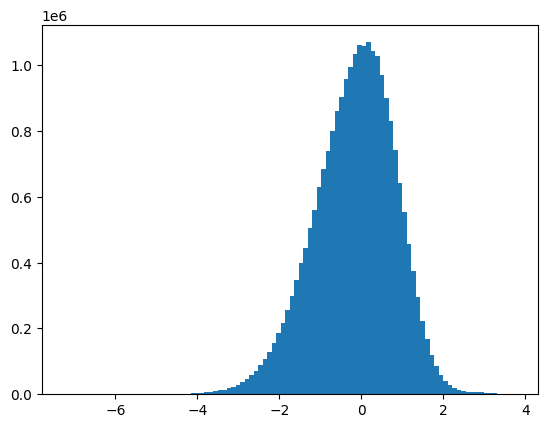

In [44]:
# plot the z-scores
plt.hist(D_z.flatten(), bins=100)

In [29]:
np.max(D_z), np.min(D_z)

(3.7502556, -7.246403)

In [44]:
# save D, I, col_query, col_lookup
np.save('lookup_embeddings_faiss_query_results.npy', D)
np.save('lookup_embeddings_faiss_query_indices.npy', I)
col_query.to_csv('lookup_embeddings_faiss_query_meta_data.tsv', sep="\t")
col_lookup.to_csv('lookup_embeddings_faiss_lookup_meta_data.tsv', sep="\t")


In [45]:
I.shape[0]

103590

In [46]:
meta = col_meta_data[I[0]]

In [49]:
meta_query = col_query.iloc[0][column]

In [50]:
meta_query

'PF01266;'

In [61]:
near_ids = []
# for i in range(I.shape[0]):
for i in range(10000):
    meta = col_meta_data[I[i]]
    meta_query = col_query.iloc[i][column]
    # if no annotation for the query, skip
    
    if meta_query is np.nan:
        continue
    # create boolean mask for proteins that have the same annotation as the query
    # print(meta_query)

    # technically, this is a partial hit. to get exact hits, use the following line

    # mask_query_in_lookup = [meta_query in meta[k] for k in range(len(meta))]
    # kind of confusing. delineate the cases of different hits based on number of Pfam/EC/etc annotations

    mask_exact = [meta_query == meta[k] for k in range(len(meta))]
    # partial hits
    if meta_query.count(';') > 1:
        available_pfs = meta_query.split(';')
        mask_partial = [[available_pfs[j] in meta[k] for j in range(len(available_pfs) - 1)] for k in range(len(meta))]
    else:
        mask_partial = [meta_query in meta[k] for k in range(len(meta))]

    
    # available_pfs = meta_query.split(';')
    # mask_partial = [[available_pfs[j] in meta[k] for j in range(len(available_pfs) - 1)] for k in range(len(meta))]
    
    near_ids.append({
        'meta': meta,
        'meta_query': meta_query,
        'exact': mask_exact,
        'partial': mask_partial,
        'S_i': D[i]
    })   

In [63]:
# save the results
np.save('conformal_pfam_with_lookup_dataset.npy', near_ids)

### Make the same dataset but for new proteins after the cutoff date

In [ ]:
query_embeddings = np.load('new_protein_embeddings.npy')

In [ ]:
# Filter for lookup proteins with annotations for the relavant aspect (don't want to transfer null annotations)
col_lookup = lookup_proteins_meta[~lookup_proteins_meta[column].isnull()]
col_lookup_embeddings = embeddings[col_lookup.index]
col_meta_data = col_lookup[column].values
